### This script is used to check BP for DCM-RNN
- Keep the majority parameters "correct".
- Calculate the loss as a function of remaining parameter.
- Check whether BP can find the targeted optimal point.

In [678]:
import importlib
import numpy as np
import scipy as sp
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import axes3d
import math as mth
from tensorflow.python.framework import ops
from IPython.display import clear_output
from scipy.interpolate import interp1d
import os,shutil
import pandas as pd
from tensorflow.python.client import timeline

In [2]:
import CBI
import population
importlib.reload(CBI)
importlib.reload(population)

<module 'population' from '/Users/yuanwang/Google_Drive/projects/Gits/DCM-RNN/population.py'>

In [681]:
global_settings=type('container', (object,), {})()
global_settings.t_delta=0.25
global_settings.n_stimuli=1
global_settings.n_recurrent_step=12
global_settings.learning_rate=0.00001

###  Create a subject

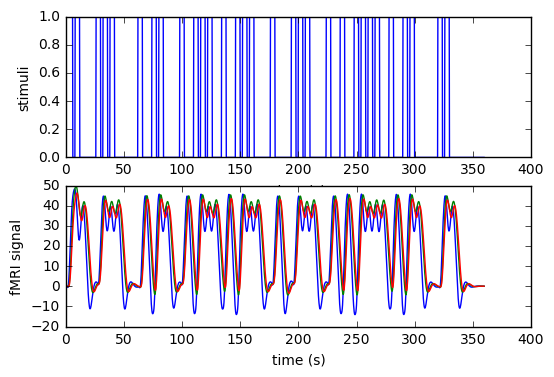

In [5]:
flags=type('container', (object,), {})()
flags.random_hemodynamic_parameter = False
flags.random_h_state_initial = False
flags.random_x_state_initial = False

s=population.get_a_subject(flags=flags)
m=CBI.configure_a_scanner(t_delta=global_settings.t_delta,n_stimuli=global_settings.n_stimuli)
u,y,x,h=m.quick_scan(s,return_x=True,return_h=True)
parameter_true=s.show_all_variable_value(False)
plt.subplot(211)
plt.plot(np.arange(m.n_time_point)*m.t_delta,u.transpose())
plt.xlabel('time (s)')
plt.ylabel('stimuli')
plt.subplot(212)
plt.plot(np.arange(m.n_time_point)*m.t_delta,y[:,0,:].transpose())
plt.xlabel('time (s)')
plt.ylabel('fMRI signal')

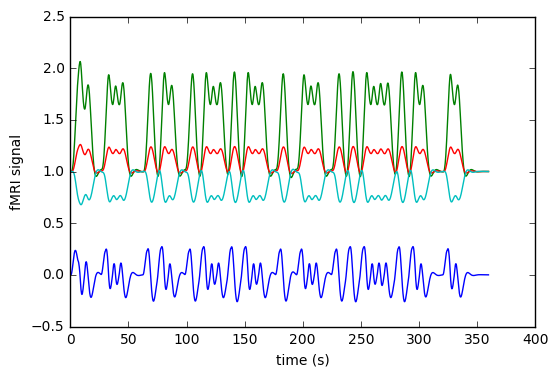

In [6]:
# plot it to check hemodynamic states to ensure they are in proper range
plt.plot(np.arange(m.n_time_point)*m.t_delta,h[2,:,:].transpose())
#plt.plot(np.arange(250,350),h[0,:,250:350].transpose())
plt.xlabel('time (s)')
plt.ylabel('fMRI signal')

### Data preparation

In [7]:
import data_helper
importlib.reload(data_helper)

<module 'data_helper' from '/Users/yuanwang/Google_Drive/projects/Gits/DCM-RNN/data_helper.py'>

In [8]:
# target u: [m.n_stimuli, n_recurrent_step]
# target x: [m.n_region, n_recurrent_step]
n_recurrent_step=global_settings.n_recurrent_step

dh=data_helper.get_a_data_helper()
dh.u=u[:]
dh.x=x[:]
dh.y=y[:]

dh.u_list=dh.cut2shape(dh.u,[m.n_stimuli, n_recurrent_step],n_recurrence=n_recurrent_step)
dh.x_list=dh.cut2shape(dh.x,[m.n_region, n_recurrent_step],n_recurrence=n_recurrent_step)
dh.y_list=dh.cut2shape(dh.y,[m.n_region, n_recurrent_step],n_recurrence=n_recurrent_step)
print('u_list has '+str(len(dh.u_list))+' segments, each of size '+str(dh.u_list[0].shape))
print('x_list has '+str(len(dh.x_list))+' segments, each of size '+str(dh.x_list[0].shape))
print('y_list has '+str(len(dh.x_list))+' segments, each of size '+str(dh.x_list[0].shape))

u_list has 120 segments, each of size (1, 12)
x_list has 120 segments, each of size (3, 12)
y_list has 120 segments, each of size (3, 12)


### Build model

In [682]:
# build DCM-RNN
ops.reset_default_graph()
import DCM_RNN
importlib.reload(DCM_RNN)
dr=DCM_RNN.DCM_RNN(m,n_recurrent_step=global_settings.n_recurrent_step,learning_rate=global_settings.learning_rate)
dr.build_a_model()
util=DCM_RNN.utilities()

In [683]:
dr.Wxx_init

array([[ 0.75,  0.  ,  0.  ],
       [ 0.  ,  0.75,  0.  ],
       [ 0.  ,  0.  ,  0.75]], dtype=float32)

In [660]:
# training summary
acc_Wxx=1-util.rMSE(dr.Wxx,s.Wxx)
acc_Wxxu=[1-util.rMSE(dr.Wxxu[n],s.Wxxu[n]) for n in range(dr.n_stimuli)]
acc_Wxxu=tf.add_n(acc_Wxxu)
acc_Wxu=1-util.rMSE(dr.Wxu,s.Wxu.reshape((m.n_region,1)))

loss_summary = tf.scalar_summary('fMRI_prediction_loss',dr.loss_y)
acc_Wxx_summary = tf.scalar_summary('acc_Wxx',acc_Wxx)
acc_Wxxu_summary = tf.scalar_summary('acc_Wxxu',acc_Wxxu)
acc_Wxu_summary = tf.scalar_summary('acc_Wxu',acc_Wxu)
opt_summary = tf.merge_summary([loss_summary, acc_Wxx_summary, acc_Wxxu_summary,acc_Wxu_summary])

summary_dir = os.path.abspath(os.path.join(os.path.curdir, "summary"))

# remove existing files
for the_file in os.listdir(summary_dir):
    file_path = os.path.join(summary_dir, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
        #elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)

In [661]:
'''# time tracking
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()'''

'# time tracking\nrun_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)\nrun_metadata = tf.RunMetadata()'

In [662]:
# open session and initilize
try:
    isess
except:
    isess = tf.InteractiveSession()
else:
    isess.close()
    isess = tf.InteractiveSession()

opt_init_all=tf.initialize_all_variables()
isess.run(opt_init_all)
# add summary
summary_writer = tf.train.SummaryWriter(summary_dir, isess.graph)

In [665]:
type(dr.test_all_variable2)

str

In [666]:
test=tf.all_variables()

In [671]:
test.name

AttributeError: 'list' object has no attribute 'name'

### Calculate loss as function as a certain subset of parameters

#### 1D version

In [286]:
importlib.reload(DCM_RNN)
util=DCM_RNN.utilities()
names=util.get_parameter_names(dr.grads_and_vars)
variable_dict=util.set_up_parameter_profile(isess.graph,names=names,mask_value_gradient=0)
variable_dict['rnn_cell/Wxu:0'].masks.gradient[0]=1
variable_dict['rnn_cell/Wxu:0'].masks.sparse[0]=0./(len(dh.u_list))/dr.t_delta


In [287]:
variable_dict['rnn_cell/Wxu:0'].masks.sparse

array([[ 0.],
       [ 0.],
       [ 0.]])

In [289]:
# test sparse penalty
# f=open('timeline.json', 'w')
loss_values_static=[]

current_value = 0.1
# set parameter value
Wxx=np.array([[-1,0,0],[0.8,-1,0.4],[0.4,0.8,-1]],dtype=np.float32)*dr.t_delta+np.eye(dr.n_region,dr.n_region,0,dtype=np.float32)
Wxxu=Wxxu=[np.array([[0,0,0],[0,0,0],[0,0,-0.4]],dtype=np.float32)*dr.t_delta for _ in range(dr.n_stimuli)]
Wxu=np.eye(dr.n_region,dr.n_stimuli,dtype=np.float32)*0.4*dr.t_delta 
Wxu[0]=current_value*dr.t_delta
dr.set_connection_matrices(isess, Wxx=Wxx, Wxxu=Wxxu, Wxu=Wxu)

n_epoch=1
for epoch in range(n_epoch):
    loss_sum=0.
    loss_sparse_sum=0.
    x_feed=np.zeros((m.n_region,1),dtype=np.float32)
    h_feed=[np.array([0.,1.,1.,1.],dtype=np.float32).reshape(4,1) for _ in range(dr.n_region)]

    for i in range(0,len(dh.u_list)):
    #for i in range(1):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.rnn_u]=dh.u_list[i]
        feed_dict[dr.y_true_input_as_array]=dh.y_list[i]
        util.append_masks_to_feed_dict(dr,feed_dict,variable_dict)

        grads_and_vars,x_feed,h_feed,loss_y,loss_sparse_list,loss_sparse = isess.run([
                                            dr.grads_and_vars,
                                            dr.x_state_final,
                                            dr.h_state_final,
                                            dr.loss_y,
                                            dr.loss_sparse_list,
                                            dr.loss_sparse], feed_dict=feed_dict)

        loss_sum+=loss_y 
        loss_sparse_sum+=loss_sparse
    loss_values_static.append(loss_sparse_sum)
    print("parameter {:g}, loss {:g}".format(current_value, loss_sum))



parameter 0.1, loss 39854.7


In [290]:
print(loss_y)
print(loss_sparse_list)
print(loss_sparse)

0.000502919
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.0


In [146]:
parameter_trained=util.show_all_variable_value(dr,isess,visFlag=False)

Wxx


,From_r0,From_r1,From_r2
To_r0,0.75,0.00,0.00
To_r1,0.20,0.75,0.10
To_r2,0.10,0.20,0.75


Wxxu_s0


,From_r0,From_r1,From_r2
To_r0,0.0,0.0,0.0
To_r1,0.0,0.0,0.0
To_r2,0.0,0.0,-0.1


Wxu


,stimuli_0
To_r0,0.025
To_r1,0.000
To_r2,0.000


hemodynamic_parameters


,alpha,E0,k,gamma,tao,epsilon,V0,TE,r0,theta0
region_0,0.32,0.34,0.65,0.41,0.98,0.4,100.0,0.03,25.0,40.299999
region_1,0.32,0.34,0.65,0.41,0.98,0.4,100.0,0.03,25.0,40.299999
region_2,0.32,0.34,0.65,0.41,0.98,0.4,100.0,0.03,25.0,40.299999


In [ ]:
n_grids = 15
loss_values_static=[]
parameter_range = np.linspace(0,0.8,n_grids)
parameter_range

In [169]:
# find loss as a function of parameters
# f=open('timeline.json', 'w')
n_grids = 15
loss_y_values_static=[]
loss_sparse_values_static=[]
loss_sparse_values_list=[]
parameter_range = np.linspace(0,0.8,n_grids)
for current_value in parameter_range:
    # set parameter value
    Wxx=np.array([[-1,0,0],[0.8,-1,0.4],[0.4,0.8,-1]],dtype=np.float32)*dr.t_delta+np.eye(dr.n_region,dr.n_region,0,dtype=np.float32)
    Wxxu=Wxxu=[np.array([[0,0,0],[0,0,0],[0,0,-0.4]],dtype=np.float32)*dr.t_delta for _ in range(dr.n_stimuli)]
    Wxu=np.eye(dr.n_region,dr.n_stimuli,dtype=np.float32)*0.4*dr.t_delta 
    Wxu[0]=current_value*dr.t_delta
    dr.set_connection_matrices(isess, Wxx=Wxx, Wxxu=Wxxu, Wxu=Wxu)
    
    n_epoch=1
    for epoch in range(n_epoch):
        loss_y_sum=0.
        loss_sparse_sum=0.
        x_feed=np.zeros((m.n_region,1),dtype=np.float32)
        h_feed=[np.array([0.,1.,1.,1.],dtype=np.float32).reshape(4,1) for _ in range(dr.n_region)]

        for i in range(0,len(dh.u_list)):
        #for i in range(1):
            feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
            feed_dict[dr.x_state_initial]=x_feed
            feed_dict[dr.rnn_u]=dh.u_list[i]
            feed_dict[dr.y_true_input_as_array]=dh.y_list[i]
            util.append_masks_to_feed_dict(dr,feed_dict,variable_dict)
            
            x_feed,h_feed,loss_y,loss_sparse,loss_sparse_list = isess.run([dr.x_state_final,
                                                dr.h_state_final,
                                                dr.loss_y,
                                                dr.loss_sparse,
                                                dr.loss_sparse_list], feed_dict=feed_dict)
            
            loss_y_sum+=loss_y
            loss_sparse_sum+=loss_sparse
            
        loss_y_values_static.append(loss_y_sum)
        loss_sparse_values_static.append(loss_sparse_sum)
        print("parameter {:g}, loss_y {:g}, loss_sparse{:g}".format(current_value, loss_y_sum,loss_sparse_sum))


parameter 0, loss_y 89586.7, loss_sparse0
parameter 0.0571429, loss_y 57410.4, loss_sparse571.429
parameter 0.114286, loss_y 35018.7, loss_sparse1142.86
parameter 0.171429, loss_y 19819.5, loss_sparse1714.29
parameter 0.228571, loss_y 9921.95, loss_sparse2285.71
parameter 0.285714, loss_y 3947.87, loss_sparse2857.14
parameter 0.342857, loss_y 888.426, loss_sparse3428.57
parameter 0.4, loss_y 6.05347e-08, loss_sparse4000
parameter 0.457143, loss_y 730.478, loss_sparse4571.43
parameter 0.514286, loss_y 2666.96, loss_sparse5142.86
parameter 0.571429, loss_y 5498.58, loss_sparse5714.29
parameter 0.628571, loss_y 8989.96, loss_sparse6285.71
parameter 0.685714, loss_y 12961.9, loss_sparse6857.14
parameter 0.742857, loss_y 17277.5, loss_sparse7428.57
parameter 0.8, loss_y 21831.7, loss_sparse8000


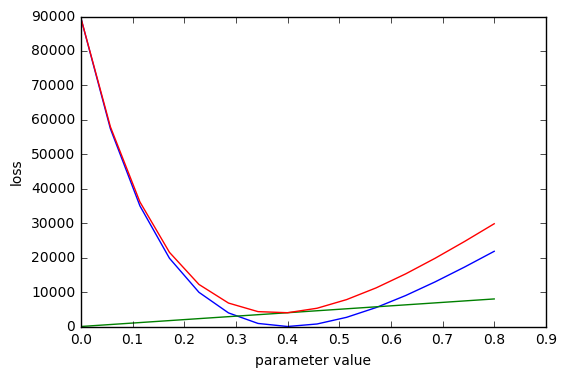

In [170]:
plt.plot(parameter_range,loss_y_values_static,parameter_range,loss_sparse_values_static,parameter_range,[i+j for i,j in zip(loss_sparse_values_static,loss_y_values_static)])
plt.xlabel('parameter value')
plt.ylabel('loss')

In [219]:
importlib.reload(DCM_RNN)
util=DCM_RNN.utilities()
names=util.get_parameter_names(dr.grads_and_vars)
variable_dict=util.set_up_parameter_profile(isess.graph,names=names,mask_value_gradient=0)
variable_dict['rnn_cell/Wxu:0'].masks.gradient[0]=1
variable_dict['rnn_cell/Wxu:0'].masks.sparse[0]=100./(len(dh.u_list))/dr.t_delta

In [220]:
# set a particular initial point
parameter_initial=0
Wxx=np.array([[-1,0,0],[0.8,-1,0.4],[0.4,0.8,-1]],dtype=np.float32)*dr.t_delta+np.eye(dr.n_region,dr.n_region,0,dtype=np.float32)
Wxxu=Wxxu=[np.array([[0,0,0],[0,0,0],[0,0,-0.4]],dtype=np.float32)*dr.t_delta for _ in range(dr.n_stimuli)]
Wxu=np.eye(dr.n_region,dr.n_stimuli,dtype=np.float32)*0.4*dr.t_delta 
Wxu[0]=parameter_initial*dr.t_delta
dr.set_connection_matrices(isess, Wxx=Wxx, Wxxu=Wxxu, Wxu=Wxu)

In [221]:
# training
# f=open('timeline.json', 'w')
loss_y_values=[]
loss_sparse_values=[]
loss_total_values=[]

parameter_values=[]
parameter_values.append(parameter_initial)
n_epoch=12
for epoch in range(n_epoch):
    loss_y_sum=0.
    loss_sparse_sum=0.
    loss_total_sum=0.
    x_feed=np.zeros((m.n_region,1),dtype=np.float32)
    h_feed=[np.array([0.,1.,1.,1.],dtype=np.float32).reshape(4,1) for _ in range(dr.n_region)]
    #for i in range(0,len(dh.u_list)):
    # do not do BP for the first segments because of initial states uncertainty 
    
    for i in range(0,5):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.rnn_u]=dh.u_list[i]
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.y_true_input_as_array]=dh.y_list[i]
        util.append_masks_to_feed_dict(dr,feed_dict,variable_dict)

        #grads_and_vars_tmp
        x_feed,h_feed, loss_y,loss_sparse,loss_total = isess.run([dr.x_state_final,dr.h_state_final, dr.loss_y,dr.loss_sparse,dr.loss_total],feed_dict=feed_dict)
        loss_y_sum+=loss_y
        loss_sparse_sum+=loss_sparse
        loss_total_sum+=loss_total
    
    for i in range(5,len(dh.u_list)):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.rnn_u]=dh.u_list[i]
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.y_true_input_as_array]=dh.y_list[i]
        util.append_masks_to_feed_dict(dr,feed_dict,variable_dict)
        
        grads_and_vars_tmp,tmp,x_feed,h_feed,loss_y,loss_sparse,loss_total, summaries, acc_Wxx_tmp,acc_Wxxu_tmp,acc_Wxu_tmp \
                                                    = isess.run([
                                                    dr.apply_gradient,
                                                    dr.x_state_predicted,
                                                    dr.x_state_final,
                                                    dr.h_state_final,
                                                    dr.loss_y,
                                                    dr.loss_sparse,
                                                    dr.loss_total,
                                                    opt_summary,
                                                    acc_Wxx,
                                                    acc_Wxxu,
                                                    acc_Wxu],
                                                    feed_dict=feed_dict)
       
                                                      #options=run_options, run_metadata=run_metadata)
        #print("segment {}, loss {:g}, acc_Wxx {:g}, acc_Wxxu {:g}, acc_Wxu {:g}"\
        #  .format(i, loss_tmp, acc_Wxx_tmp, acc_Wxxu_tmp, acc_Wxu_tmp))
        
        #isess.run(dr.apply_gradient_y,feed_dict={})
        
        loss_y_sum+=loss_y
        loss_sparse_sum+=loss_sparse
        loss_total_sum+=loss_total
        
    #print('epoch = '+str(epoch))
    parameter_tmp=isess.run(dr.Wxu)/dr.t_delta
    parameter_values.append(float(parameter_tmp[0]))   
    
    loss_y_values.append(loss_y_sum)
    loss_sparse_values.append(loss_sparse_sum)
    loss_total_values.append(loss_total_sum)
    
    print("epoch {}, loss {:g}, acc_Wxx {:g}, acc_Wxxu {:g}, acc_Wxu {:g}"\
         .format(epoch, loss_total_sum, acc_Wxx_tmp, acc_Wxxu_tmp, acc_Wxu_tmp))
    

epoch 0, loss 72432, acc_Wxx 1, acc_Wxxu 1, acc_Wxu 0.165722
epoch 1, loss 41748.1, acc_Wxx 1, acc_Wxxu 1, acc_Wxu 0.330221
epoch 2, loss 23150.8, acc_Wxx 1, acc_Wxxu 1, acc_Wxu 0.469212
epoch 3, loss 13114.3, acc_Wxx 1, acc_Wxxu 1, acc_Wxu 0.577187
epoch 4, loss 7797.42, acc_Wxx 1, acc_Wxxu 1, acc_Wxu 0.657972
epoch 5, loss 4916.4, acc_Wxx 1, acc_Wxxu 1, acc_Wxu 0.717423
epoch 6, loss 3297.93, acc_Wxx 1, acc_Wxxu 1, acc_Wxu 0.760861
epoch 7, loss 2352.74, acc_Wxx 1, acc_Wxxu 1, acc_Wxu 0.792503
epoch 8, loss 1779.72, acc_Wxx 1, acc_Wxxu 1, acc_Wxu 0.815526
epoch 9, loss 1420.26, acc_Wxx 1, acc_Wxxu 1, acc_Wxu 0.83227
epoch 10, loss 1187.88, acc_Wxx 1, acc_Wxxu 1, acc_Wxu 0.844448
epoch 11, loss 1033.75, acc_Wxx 1, acc_Wxxu 1, acc_Wxu 0.853305


In [222]:
loss_y_values

[72428.736369612569,
 41738.07886095313,
 23134.687770742399,
 13093.304823277125,
 7772.6238798564009,
 4888.8139065822834,
 3268.2991618793203,
 2321.6215701188303,
 1747.5156358063759,
 1387.2614628258616,
 1154.3045778031719,
 999.76117954944675]

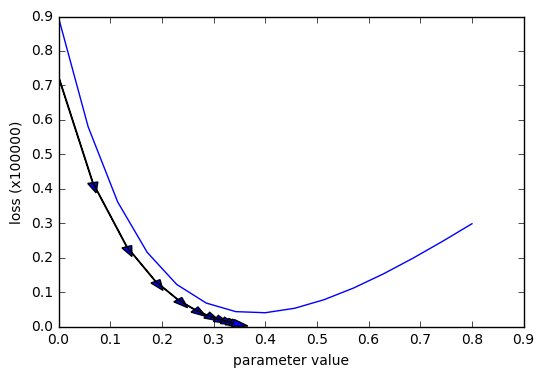

In [223]:
# plot the BP process
ax = plt.axes()
ax.plot(parameter_range,[(i+j)/100000 for i,j in zip(loss_sparse_values_static,loss_y_values_static)])
for idx in range(1,len(loss_total_values)):
    ax.arrow(float(parameter_values[idx-1]), loss_total_values[idx-1]/100000,\
             float(parameter_values[idx])-float(parameter_values[idx-1]), (loss_total_values[idx]-loss_total_values[idx-1])/100000)
plt.xlabel('parameter value')
plt.ylabel('loss (x100000)')
plt.show()

#### 2D version

In [252]:
importlib.reload(DCM_RNN)
util=DCM_RNN.utilities()
mask_value_sparse_static=500.
names=util.get_parameter_names(dr.grads_and_vars)
variable_dict=util.set_up_parameter_profile(isess.graph,names=names,mask_value_gradient=0)
variable_dict['rnn_cell/Wxu:0'].masks.gradient[1]=1
variable_dict['rnn_cell/Wxu:0'].masks.sparse[1]=mask_value_sparse_static/(len(dh.u_list))/dr.t_delta
variable_dict['rnn_cell/Wxx:0'].masks.gradient[1,0]=1
variable_dict['rnn_cell/Wxx:0'].masks.sparse[1,0]=mask_value_sparse_static/(len(dh.u_list))/dr.t_delta

In [253]:
n_grids = 13
loss_values_static=np.zeros((n_grids,n_grids))
parameter_range1 = np.linspace(0.6,1.,n_grids)    # for A21
parameter_range2 = np.linspace(-0.1,0.3,n_grids)    # for C2
print(parameter_range1)
print(parameter_range2)

[ 0.6         0.63333333  0.66666667  0.7         0.73333333  0.76666667
  0.8         0.83333333  0.86666667  0.9         0.93333333  0.96666667
  1.        ]
[-0.1        -0.06666667 -0.03333333  0.          0.03333333  0.06666667
  0.1         0.13333333  0.16666667  0.2         0.23333333  0.26666667
  0.3       ]


In [254]:
# find loss as a function of parameters
# f=open('timeline.json', 'w')
n_grids = 13
loss_values_static=np.zeros((n_grids,n_grids))
parameter_range1 = np.linspace(0.6,1.,n_grids)    # for A21
parameter_range2 = np.linspace(-0.1,0.3,n_grids)    # for C2

loss_y_values_static=np.zeros((n_grids,n_grids))
loss_sparse_values_static=np.zeros((n_grids,n_grids))
loss_total_values_static=np.zeros((n_grids,n_grids))

for idx1,current_value1 in enumerate(parameter_range1):
    for idx2,current_value2 in enumerate(parameter_range2):
    
        # set parameter value
        Wxx=np.array([[-1,0,0],[0.8,-1,0.4],[0.4,0.8,-1]],dtype=np.float32)*dr.t_delta+np.eye(dr.n_region,dr.n_region,0,dtype=np.float32)
        Wxxu=Wxxu=[np.array([[0,0,0],[0,0,0],[0,0,-0.4]],dtype=np.float32)*dr.t_delta for _ in range(dr.n_stimuli)]
        Wxu=np.eye(dr.n_region,dr.n_stimuli,dtype=np.float32)*0.4*dr.t_delta 
        Wxx[1,0]=current_value1*dr.t_delta
        Wxu[1]=current_value2*dr.t_delta
        dr.set_connection_matrices(isess, Wxx=Wxx, Wxxu=Wxxu, Wxu=Wxu)

        n_epoch=1
        for epoch in range(n_epoch):
            loss_sum=0.
            
            loss_y_sum=0.
            loss_sparse_sum=0.
            loss_total_sum=0.
            
            x_feed=np.zeros((m.n_region,1),dtype=np.float32)
            h_feed=[np.array([0.,1.,1.,1.],dtype=np.float32).reshape(4,1) for _ in range(dr.n_region)]

            for i in range(0,len(dh.u_list)):
            #for i in range(1):
                feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
                feed_dict[dr.x_state_initial]=x_feed
                feed_dict[dr.rnn_u]=dh.u_list[i]
                feed_dict[dr.y_true_input_as_array]=dh.y_list[i]
                util.append_masks_to_feed_dict(dr,feed_dict,variable_dict)

                x_feed,h_feed,loss_y,loss_sparse,loss_total = isess.run([
                                                    dr.x_state_final,
                                                    dr.h_state_final,
                                                    dr.loss_y,
                                                    dr.loss_sparse,
                                                    dr.loss_total,], feed_dict=feed_dict)

                loss_y_sum+=loss_y
                loss_sparse_sum+=loss_sparse
                loss_total_sum+=loss_total
        
            loss_y_values_static[idx1,idx2]=loss_y_sum
            loss_sparse_values_static[idx1,idx2]=loss_sparse_sum
            loss_total_values_static[idx1,idx2]=loss_total_sum
            
            print("parameter1 {:g},parameter2 {:g}, loss {:g}".format(current_value1,current_value2, loss_total_sum))



parameter1 0.6,parameter2 -0.1, loss 7500.27
parameter1 0.6,parameter2 -0.0666667, loss 4702.92
parameter1 0.6,parameter2 -0.0333333, loss 2723.25
parameter1 0.6,parameter2 0, loss 1419.38
parameter1 0.6,parameter2 0.0333333, loss 708.074
parameter1 0.6,parameter2 0.0666667, loss 460.007
parameter1 0.6,parameter2 0.1, loss 595.847
parameter1 0.6,parameter2 0.133333, loss 1049.82
parameter1 0.6,parameter2 0.166667, loss 1767.21
parameter1 0.6,parameter2 0.2, loss 2702.34
parameter1 0.6,parameter2 0.233333, loss 3817
parameter1 0.6,parameter2 0.266667, loss 5079.07
parameter1 0.6,parameter2 0.3, loss 6461.54
parameter1 0.633333,parameter2 -0.1, loss 6367.31
parameter1 0.633333,parameter2 -0.0666667, loss 3883.66
parameter1 0.633333,parameter2 -0.0333333, loss 2163.5
parameter1 0.633333,parameter2 0, loss 1074.67
parameter1 0.633333,parameter2 0.0333333, loss 541.786
parameter1 0.633333,parameter2 0.0666667, loss 441.889
parameter1 0.633333,parameter2 0.1, loss 700.809
parameter1 0.633333

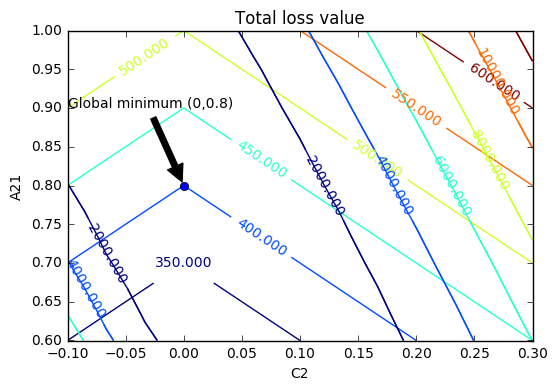

In [256]:
X, Y = np.meshgrid(parameter_range2, parameter_range1)
plt.figure()
CS=plt.contour(X, Y, loss_sparse_values_static)
plt.clabel(CS, inline=1, fontsize=10)
plt.contour(X, Y, loss_y_values_static)
CS = plt.contour(X, Y, loss_y_values_static)
plt.clabel(CS, inline=1, fontsize=10)
plt.annotate('Global minimum (0,0.8)', xy=(0, 0.8), xytext=(-0.1, 0.9),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.plot(0,0.8,'bo')
plt.title('Total loss value')
plt.xlabel('C2')
plt.ylabel('A21')

In [360]:
# set variable mask indecating the variables that can be updated
importlib.reload(DCM_RNN)
util=DCM_RNN.utilities()
names=util.get_parameter_names(dr.grads_and_vars)
mask_value_sparse=20.
variable_dict=util.set_up_parameter_profile(isess.graph,names=names,mask_value_gradient=0)
variable_dict['rnn_cell/Wxu:0'].masks.gradient[1]=1
variable_dict['rnn_cell/Wxu:0'].masks.sparse[1]=mask_value_sparse/(len(dh.u_list))/dr.t_delta
variable_dict['rnn_cell/Wxx:0'].masks.gradient[1,0]=1
variable_dict['rnn_cell/Wxx:0'].masks.sparse[1,0]=mask_value_sparse/(len(dh.u_list))/dr.t_delta

In [361]:
# set a particular initial point
parameter_initial1=1
parameter_initial2=0.5
Wxx=np.array([[-1,0,0],[0.8,-1,0.4],[0.4,0.8,-1]],dtype=np.float32)*dr.t_delta+np.eye(dr.n_region,dr.n_region,0,dtype=np.float32)
Wxxu=Wxxu=[np.array([[0,0,0],[0,0,0],[0,0,-0.4]],dtype=np.float32)*dr.t_delta for _ in range(dr.n_stimuli)]
Wxu=np.eye(dr.n_region,dr.n_stimuli,dtype=np.float32)*0.4*dr.t_delta 
Wxx[1,0]=parameter_initial1*dr.t_delta
Wxu[1]=parameter_initial2*dr.t_delta
dr.set_connection_matrices(isess, Wxx=Wxx, Wxxu=Wxxu, Wxu=Wxu)

In [367]:
# training
# f=open('timeline.json', 'w')
loss_y_values=[]
loss_sparse_values=[]
loss_total_values=[]

parameter_values1=[]
parameter_values2=[]
parameter_values1.append(parameter_initial1)
parameter_values2.append(parameter_initial2)
n_epoch=12
for epoch in range(n_epoch):
    loss_y_sum=0.
    loss_sparse_sum=0.
    loss_total_sum=0.
    x_feed=np.zeros((m.n_region,1),dtype=np.float32)
    h_feed=[np.array([0.,1.,1.,1.],dtype=np.float32).reshape(4,1) for _ in range(dr.n_region)]
    #for i in range(0,len(dh.u_list)):
    # do not do BP for the first segments because of initial states uncertainty 
    
    for i in range(0,5):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.rnn_u]=dh.u_list[i]
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.y_true_input_as_array]=dh.y_list[i]
        util.append_masks_to_feed_dict(dr,feed_dict,variable_dict)
   
        x_feed,h_feed,loss_y,loss_sparse,loss_total = isess.run([
                                                    dr.x_state_final,
                                                    dr.h_state_final,
                                                    dr.loss_y,
                                                    dr.loss_sparse,
                                                    dr.loss_total,], feed_dict=feed_dict)
        loss_y_sum+=loss_y
        loss_sparse_sum+=loss_sparse
        loss_total_sum+=loss_total
    
    for i in range(5,len(dh.u_list)):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.rnn_u]=dh.u_list[i]
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.y_true_input_as_array]=dh.y_list[i]
        util.append_masks_to_feed_dict(dr,feed_dict,variable_dict)
        #grads_and_vars_tmp
        grads_and_vars_tmp,tmp,x_feed,h_feed,loss_y,loss_sparse,loss_total, summaries, acc_Wxx_tmp,acc_Wxxu_tmp,acc_Wxu_tmp \
                                                    = isess.run([
                                                    dr.apply_gradient,
                                                    dr.x_state_predicted,
                                                    dr.x_state_final,
                                                    dr.h_state_final,
                                                    dr.loss_y,
                                                    dr.loss_sparse,
                                                    dr.loss_total,
                                                    opt_summary,
                                                    acc_Wxx,
                                                    acc_Wxxu,
                                                    acc_Wxu],
                                                    feed_dict=feed_dict)
        loss_y_sum+=loss_y
        loss_sparse_sum+=loss_sparse
        loss_total_sum+=loss_total
        
    #print('epoch = '+str(epoch))
    parameter_tmp=isess.run(dr.Wxx)/dr.t_delta
    parameter_values1.append(float(parameter_tmp[1,0]))
    parameter_tmp=isess.run(dr.Wxu)/dr.t_delta
    parameter_values2.append(float(parameter_tmp[1]))
    
    loss_y_values.append(loss_y_sum)
    loss_sparse_values.append(loss_sparse_sum)
    loss_total_values.append(loss_total_sum)
    print("epoch {}, loss_y {:g}, loss_sparse {:g}, loss_total {:g}, acc_Wxx {:g}, acc_Wxxu {:g}, acc_Wxu {:g}"\
         .format(epoch, loss_y_sum,loss_sparse_sum,loss_total_sum, acc_Wxx_tmp, acc_Wxxu_tmp, acc_Wxu_tmp))
    

epoch 0, loss_y 31.6171, loss_sparse 14.9171, loss_total 46.5342, acc_Wxx 0.98708, acc_Wxxu 1, acc_Wxu 0.967427
epoch 1, loss_y 41.7522, loss_sparse 14.8538, loss_total 56.606, acc_Wxx 0.986922, acc_Wxxu 1, acc_Wxu 0.971663
epoch 2, loss_y 49.9039, loss_sparse 14.8124, loss_total 64.7163, acc_Wxx 0.98684, acc_Wxxu 1, acc_Wxu 0.974667
epoch 3, loss_y 55.9889, loss_sparse 14.786, loss_total 70.7749, acc_Wxx 0.986809, acc_Wxxu 1, acc_Wxu 0.976824
epoch 4, loss_y 60.3189, loss_sparse 14.7699, loss_total 75.0889, acc_Wxx 0.986814, acc_Wxxu 1, acc_Wxu 0.978396
epoch 5, loss_y 63.2855, loss_sparse 14.7609, loss_total 78.0464, acc_Wxx 0.986843, acc_Wxxu 1, acc_Wxu 0.979566
epoch 6, loss_y 65.2431, loss_sparse 14.7567, loss_total 79.9998, acc_Wxx 0.986888, acc_Wxxu 1, acc_Wxu 0.980457
epoch 7, loss_y 66.4743, loss_sparse 14.7559, loss_total 81.2301, acc_Wxx 0.986944, acc_Wxxu 1, acc_Wxu 0.981156
epoch 8, loss_y 67.1925, loss_sparse 14.7572, loss_total 81.9497, acc_Wxx 0.987008, acc_Wxxu 1, acc_

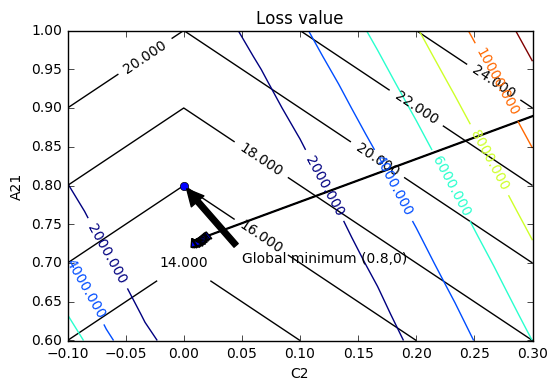

In [368]:
# plot the BP process
X, Y = np.meshgrid(parameter_range2, parameter_range1)

ax = plt.axes()
# plt.figure()
for idx in range(1,len(loss_total_values)):
    ax.arrow(float(parameter_values2[idx-1]), parameter_values1[idx-1],\
             float(parameter_values2[idx])-float(parameter_values2[idx-1]), (parameter_values1[idx]-parameter_values1[idx-1]),\
            head_width=0.01, head_length=0.01,length_includes_head=True)

CS=plt.contour(X, Y, loss_sparse_values_static/mask_value_sparse_static*mask_value_sparse,colors='k')
plt.clabel(CS, inline=1, fontsize=10)
CS = plt.contour(X, Y, loss_y_values_static)
plt.clabel(CS, inline=1, fontsize=10)

plt.annotate('Global minimum (0.8,0)', xy=(0, 0.8), xytext=(0.05, 0.7),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.plot(0,0.8,'bo')
plt.title('Loss value')
plt.xlabel('C2')
plt.ylabel('A21')
plt.show()


### N-D

In [631]:
# set variable mask indecating the variables that can be updated
importlib.reload(DCM_RNN)
util=DCM_RNN.utilities()
names=util.get_parameter_names(dr.grads_and_vars)
mask_value_sparse=0.8
variable_dict=util.set_up_parameter_profile(isess.graph,names=names,mask_value_gradient=1,mask_value_sparse=mask_value_sparse)
parameter_shape=variable_dict['rnn_cell/Wxx:0'].masks.sparse.shape
#variable_dict['rnn_cell/Wxx:0'].masks.sparse-=np.eye(parameter_shape[0],parameter_shape[1])*mask_value_sparse
variable_dict['rnn_cell/Wxx:0'].masks.sparse

array([[ 0.8,  0.8,  0.8],
       [ 0.8,  0.8,  0.8],
       [ 0.8,  0.8,  0.8]])

In [632]:
# set a particular initial point
Wxx=np.array([[-0.8,0.2,0],[0.9,-0.8,0.5],[0,0.7,-0.8]],dtype=np.float32)*dr.t_delta+np.eye(dr.n_region,dr.n_region,0,dtype=np.float32)
Wxxu=Wxxu=[np.array([[0,0,0],[-0.15,0,0],[0,0,-0.55]],dtype=np.float32)*dr.t_delta for _ in range(dr.n_stimuli)]
Wxu=np.eye(dr.n_region,dr.n_stimuli,dtype=np.float32)*0.6*dr.t_delta 
dr.set_connection_matrices(isess, Wxx=Wxx, Wxxu=Wxxu, Wxu=Wxu)

In [633]:
# training
# f=open('timeline.json', 'w')
loss_y_values=[]
loss_sparse_values=[]
loss_total_values=[]

parameter_values1=[]
parameter_values2=[]
parameter_values1.append(parameter_initial1)
parameter_values2.append(parameter_initial2)
n_epoch=50
for epoch in range(n_epoch):
    loss_y_sum=0.
    loss_sparse_sum=0.
    loss_total_sum=0.
    x_feed=np.zeros((m.n_region,1),dtype=np.float32)
    h_feed=[np.array([0.,1.,1.,1.],dtype=np.float32).reshape(4,1) for _ in range(dr.n_region)]
    #for i in range(0,len(dh.u_list)):
    # do not do BP for the first segments because of initial states uncertainty 
    
    for i in range(0,5):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.rnn_u]=dh.u_list[i]
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.y_true_input_as_array]=dh.y_list[i]
        util.append_masks_to_feed_dict(dr,feed_dict,variable_dict)
   
        x_feed,h_feed,loss_y,loss_sparse,loss_total = isess.run([
                                                    dr.x_state_final,
                                                    dr.h_state_final,
                                                    dr.loss_y,
                                                    dr.loss_sparse,
                                                    dr.loss_total,], feed_dict=feed_dict)
        loss_y_sum+=loss_y
        loss_sparse_sum+=loss_sparse
        loss_total_sum+=loss_total
    
    for i in range(5,len(dh.u_list)):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.rnn_u]=dh.u_list[i]
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.y_true_input_as_array]=dh.y_list[i]
        util.append_masks_to_feed_dict(dr,feed_dict,variable_dict)
        #grads_and_vars_tmp
        grads_and_vars_tmp,tmp,x_feed,h_feed,loss_y,loss_sparse,loss_total, summaries, acc_Wxx_tmp,acc_Wxxu_tmp,acc_Wxu_tmp \
                                                    = isess.run([
                                                    dr.apply_gradient,
                                                    dr.x_state_predicted,
                                                    dr.x_state_final,
                                                    dr.h_state_final,
                                                    dr.loss_y,
                                                    dr.loss_sparse,
                                                    dr.loss_total,
                                                    opt_summary,
                                                    acc_Wxx,
                                                    acc_Wxxu,
                                                    acc_Wxu],
                                                    feed_dict=feed_dict)
        loss_y_sum+=loss_y
        loss_sparse_sum+=loss_sparse
        loss_total_sum+=loss_total
        
    #print('epoch = '+str(epoch))
    parameter_tmp=isess.run(dr.Wxx)/dr.t_delta
    parameter_values1.append(float(parameter_tmp[1,0]))
    parameter_tmp=isess.run(dr.Wxu)/dr.t_delta
    parameter_values2.append(float(parameter_tmp[1]))
    
    loss_y_values.append(loss_y_sum)
    loss_sparse_values.append(loss_sparse_sum)
    loss_total_values.append(loss_total_sum)
    print("epoch {}, loss_y {:g}, loss_sparse {:g}, loss_total {:g}, acc_Wxx {:g}, acc_Wxxu {:g}, acc_Wxu {:g}"\
         .format(epoch, loss_y_sum,loss_sparse_sum,loss_total_sum, acc_Wxx_tmp, acc_Wxxu_tmp, acc_Wxu_tmp))
    

epoch 0, loss_y 40694.3, loss_sparse 313.525, loss_total 41007.8, acc_Wxx 0.906716, acc_Wxxu 0.4154, acc_Wxu 0.662489
epoch 1, loss_y 8202.53, loss_sparse 310.805, loss_total 8513.33, acc_Wxx 0.916992, acc_Wxxu 0.416096, acc_Wxu 0.753762
epoch 2, loss_y 5323.21, loss_sparse 310.098, loss_total 5633.31, acc_Wxx 0.923239, acc_Wxxu 0.427015, acc_Wxu 0.810762
epoch 3, loss_y 4287.41, loss_sparse 309.989, loss_total 4597.4, acc_Wxx 0.927262, acc_Wxxu 0.441401, acc_Wxu 0.84621
epoch 4, loss_y 3894.33, loss_sparse 309.996, loss_total 4204.33, acc_Wxx 0.930087, acc_Wxxu 0.456703, acc_Wxu 0.868059
epoch 5, loss_y 3732.86, loss_sparse 309.913, loss_total 4042.78, acc_Wxx 0.932227, acc_Wxxu 0.471704, acc_Wxu 0.880394
epoch 6, loss_y 3659.23, loss_sparse 309.74, loss_total 3968.97, acc_Wxx 0.933978, acc_Wxxu 0.486031, acc_Wxu 0.88657
epoch 7, loss_y 3616.21, loss_sparse 309.559, loss_total 3925.77, acc_Wxx 0.935492, acc_Wxxu 0.499867, acc_Wxu 0.889309
epoch 8, loss_y 3579.28, loss_sparse 309.321, 

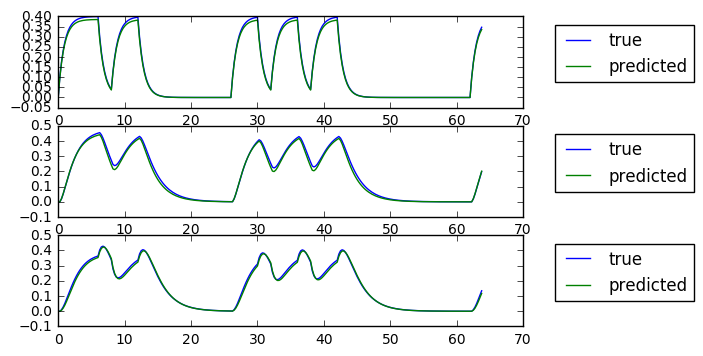

In [634]:
# visulize pridicted x_state and true x_state (after training)
x_predicted=util.forward_pass_x(dr,dh,isess)
n_monitor=256
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,x[n,0,:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,x_predicted[n,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

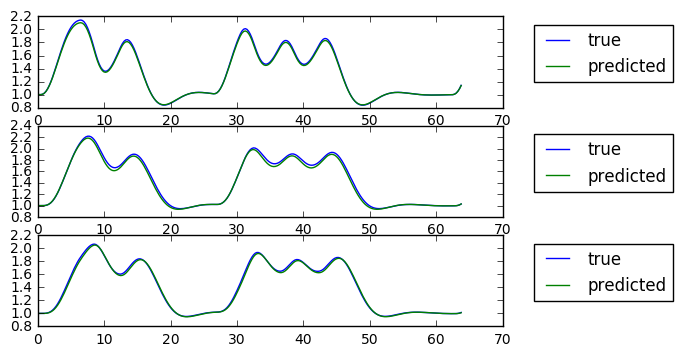

In [635]:
# visulize pridicted h_state and true h_state (before training)
h_predicted=util.forward_pass_h(dr,dh,isess)
n_monitor=256
i_h_state=1
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,h[n,i_h_state,0:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,h_predicted[n][i_h_state,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

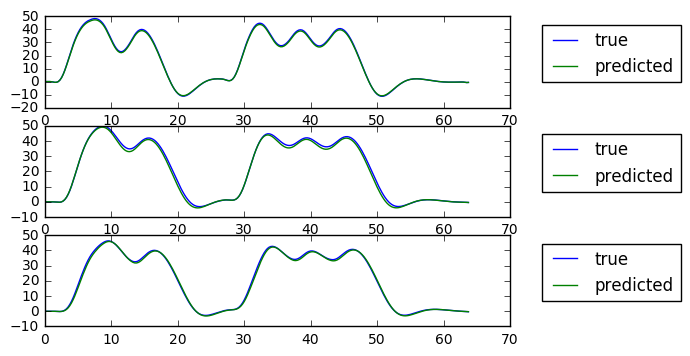

In [636]:
y_predicted=util.forward_pass_y(dr,dh,isess)
n_monitor=256#m.n_time_point
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,y[n,0,:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,y_predicted[n,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

In [637]:
importlib.reload(DCM_RNN)
util=DCM_RNN.utilities()
parameter_trained=util.show_all_variable_value(dr,isess,visFlag=False)
tmp=util.compare_parameters(parameter_trained,parameter_true,visFlag=True,parameter_list=['Wxx','Wxxu_s0','Wxu','hemodynamic_parameters'])

Wxx


set1                        set2                 difference  \
        From_r0   From_r1   From_r2 From_r0 From_r1 From_r2    From_r0   
To_r0  0.746569 -0.000004 -0.000004    0.75    0.00    0.00  -0.003431   
To_r1  0.215608  0.762967  0.067602    0.20    0.75    0.10   0.015608   
To_r2  0.068303  0.206196  0.774775    0.10    0.20    0.75  -0.031697   

                           
        From_r1   From_r2  
To_r0 -0.000004 -0.000004  
To_r1  0.012967 -0.032398  
To_r2  0.006196  0.024775

Wxxu_s0


set1                        set2                 difference  \
        From_r0   From_r1   From_r2 From_r0 From_r1 From_r2    From_r0   
To_r0  0.000004  0.000006 -0.000001     0.0     0.0     0.0   0.000004   
To_r1 -0.000220 -0.000004 -0.000003     0.0     0.0     0.0  -0.000220   
To_r2 -0.000007  0.000004 -0.095689     0.0     0.0    -0.1  -0.000007   

                           
        From_r1   From_r2  
To_r0  0.000006 -0.000001  
To_r1 -0.000004 -0.000003  
To_r2  0.000004  0.004311

Wxu


,set1,set2,difference
,stimuli_0,stimuli_0,stimuli_0
To_r0,0.097609,0.1,-0.002391
To_r1,-0.000005,0.0,-0.000005
To_r2,-0.000003,0.0,-0.000003


hemodynamic_parameters


alpha            E0             k         gamma  \
set1       region_0  3.200000e-01  3.400000e-01  6.500000e-01  4.100000e-01   
           region_1  3.200000e-01  3.400000e-01  6.500000e-01  4.100000e-01   
           region_2  3.200000e-01  3.400000e-01  6.500000e-01  4.100000e-01   
set2       region_0  3.200000e-01  3.400000e-01  6.500000e-01  4.100000e-01   
           region_1  3.200000e-01  3.400000e-01  6.500000e-01  4.100000e-01   
           region_2  3.200000e-01  3.400000e-01  6.500000e-01  4.100000e-01   
difference region_0 -7.152557e-09  3.576279e-09 -2.384186e-08 -3.576279e-09   
           region_1 -7.152557e-09  3.576279e-09 -2.384186e-08 -3.576279e-09   
           region_2 -7.152557e-09  3.576279e-09 -2.384186e-08 -3.576279e-09   

                              tao       epsilon     V0            TE    r0  \
set1       region_0  9.800000e-01  4.000000e-01  100.0  3.000000e-02  25.0   
           region_1  9.800000e-01  4.000000e-01  100.0  3.000000e-02  25.0   
           region_2  9.800000e-01  4.000000e-01  100.0  3.000000e-02  25.0   
set2       region_0  9.800000e-01  4.000000e-01  100.0  3.000000e-02  25.0   
           region_1  9.800000e-01  4.000000e-01  100.0  3.000000e-02  25.0   
           region_2  9.800000e-01  4.000000e-01  100.0  3.000000e-02  25.0   
difference region_0  1.907349e-08  5.960464e-09    0.0 -6.705523e-10   0.0   
           region_1  1.907349e-08  5.960464e-09    0.0 -6.705523e-10   0.0   
           region_2  1.907349e-08  5.960464e-09    0.0 -6.705523e-10   0.0   

                           theta0  
set1       region_0  4.030000e+01  
           region_1  4.030000e+01  
           region_2  4.030000e+01  
set2       region_0  4.030000e+01  
           region_1  4.030000e+01  
           region_2  4.030000e+01  
difference region_0 -7.629395e-07  
           region_1 -7.629395e-07  
           region_2 -7.629395e-07